In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

## 匯入所需套件

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 讀入資料集

In [3]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
x = Input(shape=(784,))

## 建立VAE
### 調整參數
### 建立三層encoding層

In [4]:
enc_1 = Dense(256, activation='sigmoid') 
enc_2 = Dense(128, activation='relu')
enc_3 = Dense(64, activation='sigmoid') 

In [5]:
enc_mean = Dense(2)
enc_log_var = Dense(2)

### 調整參數
### 建立三層decoding層

In [6]:
dec_3 = Dense(150, activation='sigmoid') 
dec_2 = Dense(350, activation='sigmoid') 
dec_1 = Dense(784, activation='sigmoid') 

In [7]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [11]:
x_hat = dec_1(dec_2(dec_3((z))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Loss 函數的建立

In [12]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 訓練

In [13]:
VAE.compile(optimizer=Adam())

In [15]:
VAE.fit(X_train, 
        batch_size=500, 
        epochs=15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 3s 44us/sample - loss: 58.2692
Epoch 2/15
60000/60000 [==============================] - 2s 33us/sample - loss: 52.8332
Epoch 3/15
60000/60000 [==============================] - 2s 35us/sample - loss: 52.8334
Epoch 4/15
60000/60000 [==============================] - 2s 34us/sample - loss: 52.8211
Epoch 5/15
60000/60000 [==============================] - 2s 35us/sample - loss: 52.5340
Epoch 6/15
60000/60000 [==============================] - 2s 37us/sample - loss: 49.8538
Epoch 7/15
60000/60000 [==============================] - 2s 33us/sample - loss: 48.8414
Epoch 8/15
60000/60000 [==============================] - 2s 40us/sample - loss: 48.0611
Epoch 9/15
60000/60000 [==============================] - 2s 32us/sample - loss: 47.7722
Epoch 10/15
60000/60000 [==============================] - 2s 33us/sample - loss: 47.4457
Epoch 11/15
60000/60000 [==============================] - 2s 32us/sample - loss: 46.8

## VAE 的視覺化

In [16]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 242,242
Trainable params: 242,242
Non-trainable params: 0
_________________________________________________________________


In [17]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               450       
_________________________________________________________________
dense_6 (Dense)              (None, 350)               52850     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               275184    
Total params: 328,484
Trainable params: 328,484
Non-trainable params: 0
_________________________________________________________________


In [18]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 8164 圖的 latent 表示為 [-0.73911124 -0.48932457]


In [19]:
indices = np.random.randint(X_train.shape[0], size=5000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

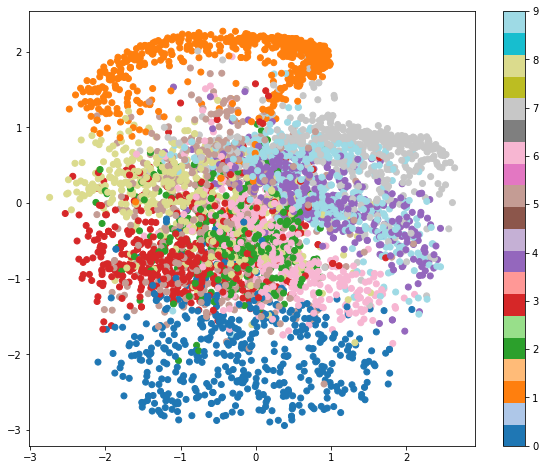

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## Decoder 的視覺化呈現

In [22]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [23]:
n=10
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

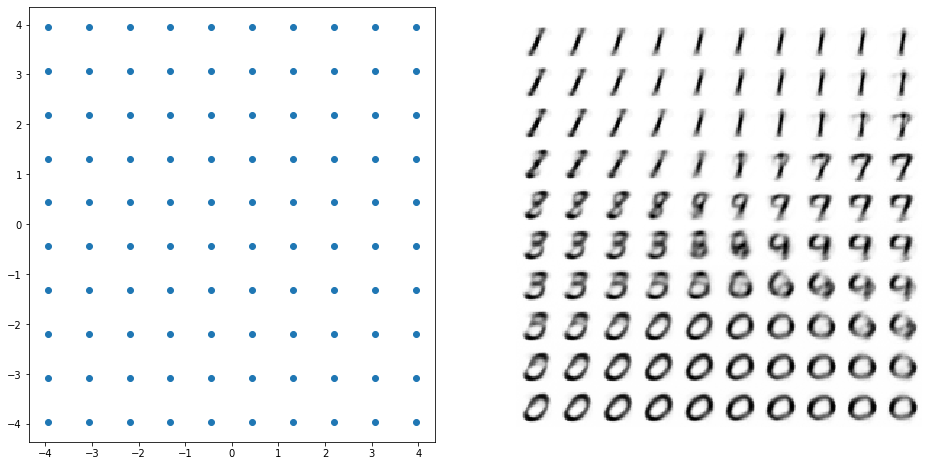

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()